# Problem C
Необходимо предсказать объем трат в следующем месяце в каждой из 184 категорий для каждого customer_id, которого нет в обучающей выборке customers_gender_train.csv, но есть в transactions.csv. Итоговый файл должен содержать предсказания по 184 * 3 000 = 552 000 объектам.<br>
Объем трат пользователя в конкретной категории считается как сумма всех расходных транзакций этого пользователя в текущей категории. https://contest.sdsj.ru/<br>
<br>
The problem is to predict spendings of each customer (3000 unique ids) in each category (184 total) for the next month

In [1]:
import pandas as pd
import lifetimes as lf
import numpy as np
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

trans = pd.read_csv('transactions.csv')
tr = pd.read_csv('customers_gender_train.csv')
test_ids = set(trans.customer_id.unique()) - set(tr.customer_id.unique())

trans = trans[trans.amount<0]

Need to add correct date, because model needs correct month<br>
This is not an optimal way to do it, but it only has to be executed once per competition

In [2]:
dt_index = pd.date_range(start = pd.to_datetime('2015-01-01') - pd.DateOffset(153), periods=457, freq='D')
trans['day'] = trans.tr_datetime.apply(lambda x: x.split(' ')[0]).astype(int)
trans['exact_date'] = trans.day.replace({x: list(dt_index.astype(str))[x] for x in range(457)})
trans['exact_date'] = trans['exact_date'] + ' ' + trans.tr_datetime.apply(lambda x: x.split(' ')[1].replace('60', '59'))
trans['date'] = pd.to_datetime(trans['exact_date'], format='%Y-%m-%d %H:%M:%S')
trans.drop(labels = ['tr_datetime', 'tr_type', 'term_id', 'exact_date', 'day'], axis = 1, inplace=True)
trans.head()

,customer_id,mcc_code,amount,date
0,39026145,4814,-2245.92,2014-08-01 10:23:26
2,39026145,4829,-56147.89,2014-08-02 10:20:56
3,39026145,5499,-1392.47,2014-08-02 10:39:54
4,39026145,5499,-920.83,2014-08-03 15:33:42
5,39026145,5541,-14643.37,2014-08-03 15:53:49


## Lifetimes approach
Link to module: https://github.com/CamDavidsonPilon/lifetimes

* So, the idea is that for the next period I need probability of buying smth in a category. Then multiply it by some estimate of spending volume. These are not separate tasks, yet this view of the problem greatly simplifies the solution
* For the probability I fit BG/NBD model from Lifetimes. You can get all the assumptions about probabilities in the paper http://mktg.uni-svishtov.bg/ivm/resources/Counting_Your_Customers.pdf
* For the amount the simplest way is to use some average of previous purchases. Here I use mean monthly volume for each customer and mcc pairs

Pros of this approach ate that it is simple and intuitive, it also very naturaly deals with zeros in data<br>
Cons - initially this method was created for LTV prediction, yet analogy with LTV in this problem is not fully correct


### Data preprocessing

Group data by months/mcc_code/customer_id.<br>
Need to transform detailed data into monthly transactional data.

In [3]:
monthly_data = trans.set_index('date').groupby(['customer_id', 'mcc_code']).resample('m').amount.sum().dropna().reset_index()
monthly_data.head()

,customer_id,mcc_code,date,amount
0,6815,4814,2014-08-31,-8983.68
1,6815,4814,2014-09-30,-15721.44
2,6815,4814,2014-10-31,-17967.36
3,6815,4814,2014-11-30,-11229.60
4,6815,4814,2014-12-31,-24705.10


Separate into train and validation. Validation on October 2015

In [4]:
train_monthly = monthly_data[monthly_data.date<pd.to_datetime('2015-10-01')]
test_monthly = monthly_data[monthly_data.date>=pd.to_datetime('2015-10-01')]

Lifetimes uses concepts of Frequency/Recency/Age of purchase history. For each customer monthly data of purchases in mcc we have:
1. Age - number of periods since first purchase.
2. Recency - if customer spends money in mcc more than once, then it is his Age at last purchase, otherwise 0
3. Freqency - number of periods, when customer bought smth

It looks like the following:

In [6]:
temp_train = lf.utils.summary_data_from_transaction_data(train_monthly[train_monthly.mcc_code==5942], 
                                            customer_id_col = 'customer_id',
                                            datetime_col = 'date',
                                            observation_period_end = datetime(2015, 9, 30),
                                            freq = 'm')
temp_train.head()

,frequency,recency,T
customer_id,,,
38084,0.0,0.0,7.0
42096,4.0,6.0,13.0
81626,3.0,12.0,12.0
117556,2.0,10.0,10.0
126935,1.0,4.0,9.0


These are the only three features for predicting probability of payment in the next period of time(which is the same as number of purchases for 1 unit of time predicted by the model, because we only have 1 "purchase" per month and month is unit of time here)

c:\anaconda3\lib\site-packages\lifetimes\estimation.py:557: RuntimeWarning: invalid value encountered in log
  A_4 = log(a) - log(b + freq - 1) - (r + freq) * log(rec + alpha)


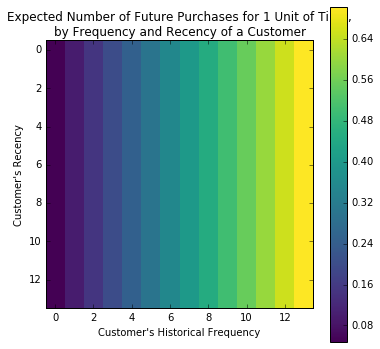

In [7]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(temp_train['frequency'], temp_train['recency'], temp_train['T'])
plt.figure(figsize=(6,6))
plot_frequency_recency_matrix(bgf, cmap=plt.get_cmap('viridis'))
plt.show()

There is no any complex relations in the probability and frequency/recency due to structure of the data. Model works far better for data with more time. Yet, the method gives an ok estimate for this case.

### Validate model

This part works maybe 8-14 minutes. You can skip it if you want to generate LB solution

In [8]:
df=pd.DataFrame()
#Each mcc_code has its own model
for mcc in monthly_data.mcc_code.unique():
    temp_train = lf.utils.summary_data_from_transaction_data(train_monthly[train_monthly.mcc_code==mcc], 
                                                customer_id_col = 'customer_id',
                                                datetime_col = 'date',
                                                observation_period_end = datetime(2015, 9, 30),
                                                freq = 'm')
    # Real values on validation
    real_test = test_monthly[test_monthly.mcc_code==mcc]
    
    bgf = BetaGeoFitter(penalizer_coef=0.0)
    bgf.fit(temp_train['frequency'], temp_train['recency'], temp_train['T'])
    
    # Difficult things should be done in one line
    # Here for each client on train I get probabilities for the next period, mean monthly volume and real volumes
    result = (real_test.merge(bgf.predict(1, temp_train['frequency'], temp_train['recency'], temp_train['T']).to_frame(), 
                                left_on='customer_id', 
                                right_index=True, how='outer')
                        .merge(train_monthly[train_monthly.mcc_code==mcc].sort_values('date').groupby('customer_id').amount.mean().to_frame(),
                               left_on='customer_id',
                               right_index=True,
                               how='outer')).rename(columns = {0:'prob'})
    
    result['TR'] = result['customer_id'].map(temp_train['T'] - temp_train['recency']).fillna(0)
    result['age'] = result['customer_id'].map(temp_train['T']).fillna(0)

    # "Tuning coefficient" for probability as model predicts large probabilities for new clients
    # Ideally coefficients should be different for every mcc. This was tuned on category 4829
    result['mult'] = 1
    result.loc[(result['age']-result['TR'])==0, 'mult'] = 0.6
    result.loc[(result['age']-result['TR'])==1, 'mult'] = 0.76666
    
    # Probability goes from inside of the logarithm as the optimization task is rmsle
    result['log_prediction'] = (result['prob']*np.log(np.abs(result['amount_y'])+1)*result['mult']).fillna(0)
    result['log_real'] = np.log(np.abs(result['amount_x'])+1)
    
    # Add zeros to the model and add result for mcc to overall results on validation
    result = result.set_index('customer_id').loc[trans.customer_id.unique()][['log_prediction', 'log_real', 'prob', 'amount_y']].reset_index().fillna(0)
    result['mcc_code'] = mcc
    df = df.append(result, ignore_index=True)
    
    temp_error = np.sqrt(np.sum(np.power(result['log_prediction']-result['log_real'], 2)/result.shape[0]))
    print('For mcc {0} have error {1}'.format(mcc, temp_error))
print('Mean error ', np.sqrt(np.sum(np.power(df['log_prediction'] - df['log_real'],2))/df.shape[0]))

c:\anaconda3\lib\site-packages\lifetimes\estimation.py:557: RuntimeWarning: invalid value encountered in log
  A_4 = log(a) - log(b + freq - 1) - (r + freq) * log(rec + alpha)


For mcc 4814 have error 2.886130610522651
For mcc 5311 have error 2.2417432636334635
For mcc 5411 have error 3.9382243867174993
For mcc 5921 have error 2.4382115784929335
For mcc 6011 have error 3.889920231179471
For mcc 4829 have error 4.2378718387881475
For mcc 5331 have error 3.2010956501284316
For mcc 5399 have error 1.2257308760032435
For mcc 5499 have error 3.446536754647921
For mcc 5541 have error 3.093661675142667
For mcc 5735 have error 1.1068034404820917
For mcc 5912 have error 3.7276529694703164
For mcc 5732 have error 2.0399794103254134
For mcc 4511 have error 1.4329800412480485
For mcc 4722 have error 0.9624684500639002
For mcc 5200 have error 2.2312364354080576
For mcc 5211 have error 2.418810142469986
For mcc 5641 have error 2.053923232624509
For mcc 5661 have error 2.7629262660094276
For mcc 5691 have error 2.89535211150668
For mcc 5719 have error 1.0696087559322904
For mcc 5722 have error 2.016471526643619
For mcc 5734 have error 0.7740001102414786
For mcc 5814 have er

Xgboost can be used to predict probability, it gives slightly different result.

### Make LB prediction

The same steps as in validation. All data is used for training

In [9]:
error = 0
final = pd.DataFrame()
cnt = 0 # Watching progress. tqdm can also be used
for mcc in monthly_data.mcc_code.unique():
    cnt+=1
    temp = lf.utils.summary_data_from_transaction_data(monthly_data[monthly_data.mcc_code==mcc], 
                                                customer_id_col = 'customer_id',
                                                datetime_col = 'date',
                                                observation_period_end = datetime(2015, 10, 31),
                                                freq = 'm')
    old_amount = monthly_data[monthly_data.mcc_code==mcc].sort_values('date').groupby('customer_id').amount.mean().to_frame()
    bgf = BetaGeoFitter(penalizer_coef=0.0)
    bgf.fit(temp['frequency'], temp['recency'], temp['T'])
    res = old_amount.merge(bgf.predict(1, temp['frequency'], temp['recency'], temp['T']).to_frame().rename(columns={0:'prob'}),
                           left_index=True, right_index=True, how='outer')
    res.reset_index(inplace=True)
    res['TR'] = (res['customer_id'].map(temp['T'] - temp['recency'])).fillna(0)
    res['age'] = res['customer_id'].map(temp['T']).fillna(0)

    res['mult'] = 1
    res.loc[(res['age']-res['TR'])==0, 'mult'] = 0.6
    res.loc[(res['age']-res['TR'])==1, 'mult'] = 0.76666
    
    # Get log, multiply by probability and then back to nominal value
    res['volume'] = np.exp(np.log(-res['amount']+1)*res['prob']*res['mult'])-1

    res.set_index('customer_id', inplace=True)
    # Add zeros for those who didn't ever spend anything
    res = res.loc[test_ids].fillna(0)
    res.reset_index(inplace=True)
    res['mcc_code'] = mcc
    del res['prob']
    del res['amount']
    
    if cnt%10 == 0:
        print('Done ', cnt)
    final = final.append(res, ignore_index=True)
    
if final.shape[0] == 3000*184:
    print('Correct number of rows')
    final[['customer_id', 'mcc_code', 'volume']].to_csv('submit_3.csv', index=False)
else:
    print('Smth went wrong, you have {0} rows'.format(final.shape[0]))

c:\anaconda3\lib\site-packages\lifetimes\estimation.py:557: RuntimeWarning: invalid value encountered in log
  A_4 = log(a) - log(b + freq - 1) - (r + freq) * log(rec + alpha)


Done  10
Done  20
Done  30
Done  40
Done  50
Done  60
Done  70
Done  80
Done  90
Done  100
Done  110
Done  120
Done  130
Done  140
Done  150
Done  160
Done  170
Done  180
Correct number of rows
